<a href="https://colab.research.google.com/github/TamaraMaggioni/DiploDatos2021/blob/main/AnalisisYCuracion/Entregable_Parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Exploración y Curación de Datos**

*Edición 2021*

----

# Trabajo práctico entregable - parte 2


En el ejercicio 1 de la parte 1 del entregable seleccionaron las filas y columnas relevantes al problema de predicción de precios de una propiedad. Además de ello, tuvieron que reducir el número de valores posibles para las variables categóricas utilizando información de dominio.

En el ejercicio 2 de la parte 1 del entregable imputaron los valores faltantes de las columnas `Suburb` y las columnas obtenidas a partir del conjunto de datos `airbnb`.

En esta notebook, **se utilizará resultado de dichas operaciones.**


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_context('talk')

In [ ]:
#Importamos el dataframe que creamos en el entregable anterior:
url = 'https://raw.githubusercontent.com/fnbellomo/DiploDatos2021/main/02_AnalisisYCuracion/melb_df_processed.csv'
melb_df = pd.read_csv(url)
melb_df.head()

,type,lat,lng,distance,price,year_built,land_size,building_area,rooms,bathroom,car,suburb_grouped,count_1km,price_mean_1km,review_mean_1km,count_2km,price_mean_2km,review_mean_2km,count_2.5km,price_mean_2.5km,review_mean_2.5km,council_area
0,h,-37.7996,144.9984,2.5,1480000.0,NaN,202.0,NaN,2,1,1.0,Abbotsford,205.0,115.312195,9.652941,1146.0,120.191972,9.821814,1799.0,119.989994,9.850208,Yarra
1,h,-37.8079,144.9934,2.5,1035000.0,1900.0,156.0,79.0,2,1,0.0,Abbotsford,424.0,123.297170,9.785311,1449.0,122.149068,9.852740,2002.0,122.017483,9.854309,Yarra
2,h,-37.8093,144.9944,2.5,1465000.0,1900.0,134.0,150.0,3,2,0.0,Abbotsford,388.0,118.878866,9.786834,1389.0,122.575954,9.850401,2028.0,122.054241,9.845728,Yarra
3,h,-37.7969,144.9969,2.5,850000.0,NaN,94.0,NaN,3,2,1.0,Abbotsford,203.0,121.965517,9.674699,1150.0,119.034783,9.822079,1826.0,118.261227,9.846995,Yarra
4,h,-37.8072,144.9941,2.5,1600000.0,2014.0,120.0,142.0,4,1,2.0,Abbotsford,398.0,121.683417,9.763636,1421.0,122.434201,9.849913,1942.0,121.684346,9.859615,Yarra


## Ejercicio 1: Encoding

1. Seleccionar todas las filas y columnas del conjunto de datos obtenido en la parte 1 del entregable, **excepto** `BuildingArea` y `YearBuilt`, que volveremos a imputar más adelante.

2. Aplicar una codificación One-hot encoding a cada fila, tanto para variables numéricas como categóricas. Si lo consideran necesario, pueden volver a reducir el número de categorías únicas.

Algunas opciones:
  1. Utilizar `OneHotEncoder` junto con el parámetro `categories` para las variables categóricas y luego usar `numpy.hstack` para concatenar el resultado con las variables numéricas. 
  2. `DictVectorizer` con algunos pasos de pre-proceso previo.

Recordar también que el atributo `pandas.DataFrame.values` permite acceder a la matriz de numpy subyacente a un DataFrame.


Tenemos en nuestro Dataframe una columna categórica llamada "suburb_grouped" con 251 suburbios únicos. También tenemos "Council_area" con 33 áreas únicas. Como debemos limitar el análisis a categóricas con 30/40 valores únicos, y crear una categoría "otros" con el resto (usando el handle_unknown='ignore' de la clase), haremos lo siguiente.
En vez de meter 220 suburbios en una categoría "otros", nos parece mejor dropear esa columna, y realizar el encoding y la imputación directamente con la columna "council_area", que ya tiene la cantidad aproximada de columnas que nos va a permitir después imputar con KNN sin quedarnos sin memoria...

In [ ]:
melb_df = melb_df.drop(['building_area', 'year_built','suburb_grouped'], axis=1)

Para la categorización de columnas numéricas, tomaremos las columnas de Rooms, bathroom,	car, distance y price_mean_1km. No se hará sobre el total de columnas numéricas, para limitar el tamaño de la matriz final.
Para las columnas de Distance y price_mean_1km, deberemos crear rangos numéricos (bins) antes de pasarlos por el encoding. Estos bins se crean utilizando los deciles de cada feature, con la función qcut:


In [ ]:
price_labels = [str(i) for i in pd.qcut(melb_df.price_mean_1km,10).unique().sort_values().tolist()[:-1]]
melb_df['price_mean_1km_cat'] = pd.qcut(melb_df.price_mean_1km,10,labels=price_labels)

In [ ]:
distance_labels = [str(i) for i in pd.qcut(melb_df.distance,10).unique().sort_values().tolist()]
melb_df['distance_cat'] = pd.qcut(melb_df.distance,10,labels=distance_labels)
#Se completan los nan
melb_df.price_mean_1km_cat.fillna('(97.371, 102.838]', inplace=True)
melb_df.car.fillna(2.0,inplace=True)

Definimos a las 30 categorías más relevantes dentro de la columna "council_area", y sumamos el resto de categorías para type, rooms, bathroom, car, y las recientemente categorizadas "distance" y "price_mean_1km":

In [ ]:
encoded_columns = ['council_area','type', 'rooms','bathroom', 'car',  'distance_cat', 'price_mean_1km_cat']
categories = [melb_df[col].value_counts().index.sort_values().tolist()[:30] for col in encoded_columns]
categories

[['Banyule',
  'Bayside',
  'Boroondara',
  'Brimbank',
  'Cardinia',
  'Casey',
  'Darebin',
  'Frankston',
  'Glen Eira',
  'Greater Dandenong',
  'Hobsons Bay',
  'Hume',
  'Kingston',
  'Knox',
  'Macedon Ranges',
  'Manningham',
  'Maribyrnong',
  'Maroondah',
  'Melbourne',
  'Melton',
  'Monash',
  'Moonee Valley',
  'Moorabool',
  'Moreland',
  'Nillumbik',
  'Port Phillip',
  'Stonnington',
  'Unavailable',
  'Whitehorse',
  'Whittlesea'],
 ['h', 't', 'u'],
 [1, 2, 3, 4, 5, 6, 7, 8, 10],
 [1, 2, 3, 4, 5, 6, 8],
 [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0],
 ['(-0.001, 3.6]',
  '(3.6, 5.5]',
  '(5.5, 6.9]',
  '(6.9, 8.0]',
  '(8.0, 9.3]',
  '(9.3, 11.2]',
  '(11.2, 12.1]',
  '(12.1, 13.8]',
  '(13.8, 16.1]',
  '(16.1, 47.3]'],
 ['(11.999, 64.379]',
  '(64.379, 77.308]',
  '(77.308, 85.0]',
  '(85.0, 91.448]',
  '(91.448, 97.371]',
  '(97.371, 102.838]',
  '(102.838, 109.371]',
  '(109.371, 117.824]',
  '(117.824, 126.959]',
  '(126.959, 280.0]']]

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
categorical_encoder = OneHotEncoder(categories=categories, handle_unknown='ignore', sparse=False)
categorical_encoder.fit(melb_df[encoded_columns])
categorical_encoder.categories_

[array(['Banyule', 'Bayside', 'Boroondara', 'Brimbank', 'Cardinia',
        'Casey', 'Darebin', 'Frankston', 'Glen Eira', 'Greater Dandenong',
        'Hobsons Bay', 'Hume', 'Kingston', 'Knox', 'Macedon Ranges',
        'Manningham', 'Maribyrnong', 'Maroondah', 'Melbourne', 'Melton',
        'Monash', 'Moonee Valley', 'Moorabool', 'Moreland', 'Nillumbik',
        'Port Phillip', 'Stonnington', 'Unavailable', 'Whitehorse',
        'Whittlesea'], dtype=object),
 array(['h', 't', 'u'], dtype=object),
 array([ 1,  2,  3,  4,  5,  6,  7,  8, 10]),
 array([1, 2, 3, 4, 5, 6, 8]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 array(['(-0.001, 3.6]', '(3.6, 5.5]', '(5.5, 6.9]', '(6.9, 8.0]',
        '(8.0, 9.3]', '(9.3, 11.2]', '(11.2, 12.1]', '(12.1, 13.8]',
        '(13.8, 16.1]', '(16.1, 47.3]'], dtype=object),
 array(['(11.999, 64.379]', '(64.379, 77.308]', '(77.308, 85.0]',
        '(85.0, 91.448]', '(91.448, 97.371]', '(97.371, 102.838]',
        '(102.838, 109.371]', 

In [ ]:
encoded = categorical_encoder.transform(melb_df[encoded_columns])
encoded.shape

(12536, 80)

In [ ]:
melb_df.head()

,type,lat,lng,distance,price,land_size,rooms,bathroom,car,count_1km,price_mean_1km,review_mean_1km,count_2km,price_mean_2km,review_mean_2km,count_2.5km,price_mean_2.5km,review_mean_2.5km,council_area,price_mean_1km_cat,distance_cat
0,h,-37.7996,144.9984,2.5,1480000.0,202.0,2,1,1.0,205.0,115.312195,9.652941,1146.0,120.191972,9.821814,1799.0,119.989994,9.850208,Yarra,"(109.371, 117.824]","(-0.001, 3.6]"
1,h,-37.8079,144.9934,2.5,1035000.0,156.0,2,1,0.0,424.0,123.297170,9.785311,1449.0,122.149068,9.852740,2002.0,122.017483,9.854309,Yarra,"(117.824, 126.959]","(-0.001, 3.6]"
2,h,-37.8093,144.9944,2.5,1465000.0,134.0,3,2,0.0,388.0,118.878866,9.786834,1389.0,122.575954,9.850401,2028.0,122.054241,9.845728,Yarra,"(117.824, 126.959]","(-0.001, 3.6]"
3,h,-37.7969,144.9969,2.5,850000.0,94.0,3,2,1.0,203.0,121.965517,9.674699,1150.0,119.034783,9.822079,1826.0,118.261227,9.846995,Yarra,"(117.824, 126.959]","(-0.001, 3.6]"
4,h,-37.8072,144.9941,2.5,1600000.0,120.0,4,1,2.0,398.0,121.683417,9.763636,1421.0,122.434201,9.849913,1942.0,121.684346,9.859615,Yarra,"(117.824, 126.959]","(-0.001, 3.6]"


Juntamos las columnas tras el encoding, con las numéricas que no hemos codificado para evitar demasiadas columnas (por ejemplo, latitud y longitud). Obtenemos una matriz "melb_df_array" de 92 columnas (las 80 que codificamos, y 12 numéricas, que en su mayoría provienen del dataset de airbnb)

In [ ]:
melb_df_array = np.hstack((encoded, melb_df.drop(encoded_columns + ['price_mean_1km','distance'], axis=1)))
melb_df_array.shape

(12536, 92)

## Ejercicio 2: Imputación por KNN

En el teórico se presentó el método `IterativeImputer` para imputar valores faltantes en variables numéricas. Sin embargo, los ejemplos presentados sólo utilizaban algunas variables numéricas presentes en el conjunto de datos. En este ejercicio, utilizaremos la matriz de datos codificada para imputar datos faltantes de manera más precisa.

1. Agregue a la matriz obtenida en el punto anterior las columnas `YearBuilt` y `BuildingArea`.
2. Aplique una instancia de `IterativeImputer` con un estimador `KNeighborsRegressor` para imputar los valores de las variables. ¿Es necesario estandarizar o escalar los datos previamente?
3. Realice un gráfico mostrando la distribución de cada variable antes de ser imputada, y con ambos métodos de imputación.

In [ ]:
# Vuelvo a traer el dataframe original
url = 'https://raw.githubusercontent.com/fnbellomo/DiploDatos2021/main/02_AnalisisYCuracion/melb_df_processed.csv'
melb_df_missingcols = pd.read_csv(url)
melb_df_missingcols.head()

,type,lat,lng,distance,price,year_built,land_size,building_area,rooms,bathroom,car,suburb_grouped,count_1km,price_mean_1km,review_mean_1km,count_2km,price_mean_2km,review_mean_2km,count_2.5km,price_mean_2.5km,review_mean_2.5km,council_area
0,h,-37.7996,144.9984,2.5,1480000.0,NaN,202.0,NaN,2,1,1.0,Abbotsford,205.0,115.312195,9.652941,1146.0,120.191972,9.821814,1799.0,119.989994,9.850208,Yarra
1,h,-37.8079,144.9934,2.5,1035000.0,1900.0,156.0,79.0,2,1,0.0,Abbotsford,424.0,123.297170,9.785311,1449.0,122.149068,9.852740,2002.0,122.017483,9.854309,Yarra
2,h,-37.8093,144.9944,2.5,1465000.0,1900.0,134.0,150.0,3,2,0.0,Abbotsford,388.0,118.878866,9.786834,1389.0,122.575954,9.850401,2028.0,122.054241,9.845728,Yarra
3,h,-37.7969,144.9969,2.5,850000.0,NaN,94.0,NaN,3,2,1.0,Abbotsford,203.0,121.965517,9.674699,1150.0,119.034783,9.822079,1826.0,118.261227,9.846995,Yarra
4,h,-37.8072,144.9941,2.5,1600000.0,2014.0,120.0,142.0,4,1,2.0,Abbotsford,398.0,121.683417,9.763636,1421.0,122.434201,9.849913,1942.0,121.684346,9.859615,Yarra


In [ ]:
#Elijo las columnas que me interesan volver a agrupar
melb_df_missingcols = melb_df_missingcols[['year_built', 'building_area']]
melb_df_missingcols.head()

,year_built,building_area
0,NaN,NaN
1,1900.0,79.0
2,1900.0,150.0
3,NaN,NaN
4,2014.0,142.0


In [ ]:
#Uno estas dos columnas al dataframe anterior, previo al OneHotEncoder, con un join (es decir, unimos por los índices):
melb_df = melb_df.join(melb_df_missingcols)
melb_df.head()

,type,lat,lng,distance,price,land_size,rooms,bathroom,car,count_1km,price_mean_1km,review_mean_1km,count_2km,price_mean_2km,review_mean_2km,count_2.5km,price_mean_2.5km,review_mean_2.5km,council_area,price_mean_1km_cat,distance_cat,year_built,building_area
0,h,-37.7996,144.9984,2.5,1480000.0,202.0,2,1,1.0,205.0,115.312195,9.652941,1146.0,120.191972,9.821814,1799.0,119.989994,9.850208,Yarra,"(109.371, 117.824]","(-0.001, 3.6]",NaN,NaN
1,h,-37.8079,144.9934,2.5,1035000.0,156.0,2,1,0.0,424.0,123.297170,9.785311,1449.0,122.149068,9.852740,2002.0,122.017483,9.854309,Yarra,"(117.824, 126.959]","(-0.001, 3.6]",1900.0,79.0
2,h,-37.8093,144.9944,2.5,1465000.0,134.0,3,2,0.0,388.0,118.878866,9.786834,1389.0,122.575954,9.850401,2028.0,122.054241,9.845728,Yarra,"(117.824, 126.959]","(-0.001, 3.6]",1900.0,150.0
3,h,-37.7969,144.9969,2.5,850000.0,94.0,3,2,1.0,203.0,121.965517,9.674699,1150.0,119.034783,9.822079,1826.0,118.261227,9.846995,Yarra,"(117.824, 126.959]","(-0.001, 3.6]",NaN,NaN
4,h,-37.8072,144.9941,2.5,1600000.0,120.0,4,1,2.0,398.0,121.683417,9.763636,1421.0,122.434201,9.849913,1942.0,121.684346,9.859615,Yarra,"(117.824, 126.959]","(-0.001, 3.6]",2014.0,142.0


Dataframe con imputación KNN sin tomar en cuenta las columnas categóricas

In [ ]:
#Importamos los paquetes de cada librería para hacer la imputación del vecino más cercano:
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer

#Hacemos una copia de la matriz, para no cambiar los datos originales
melb_data_knn_num = melb_df.drop(['type', 'council_area', 'distance_cat', 'price_mean_1km_cat'], axis=1).copy()
melb_data_knn_num.head(1)

,lat,lng,distance,price,land_size,rooms,bathroom,car,count_1km,price_mean_1km,review_mean_1km,count_2km,price_mean_2km,review_mean_2km,count_2.5km,price_mean_2.5km,review_mean_2.5km,year_built,building_area
0,-37.7996,144.9984,2.5,1480000.0,202.0,2,1,1.0,205.0,115.312195,9.652941,1146.0,120.191972,9.821814,1799.0,119.989994,9.850208,NaN,NaN


In [ ]:
from sklearn import preprocessing
#Estandarizamos las variables del dataframe
x = melb_data_knn_num.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
melb_data_knn_num = pd.DataFrame(x_scaled)
melb_data_knn_num


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.485089,0.517651,0.052854,0.372995,0.223831,0.111111,0.000000,0.1,0.052296,0.385493,0.956618,0.186858,0.568198,0.961817,0.255612,0.584969,0.964335,NaN,NaN
1,0.474160,0.513083,0.052854,0.254011,0.172606,0.111111,0.000000,0.0,0.108163,0.415288,0.973164,0.236263,0.580304,0.968444,0.284456,0.599346,0.965312,0.297619,0.197995
2,0.472317,0.513997,0.052854,0.368984,0.148107,0.222222,0.142857,0.0,0.098980,0.398802,0.973354,0.226480,0.582944,0.967943,0.288150,0.599607,0.963269,0.297619,0.375940
3,0.488644,0.516281,0.052854,0.204545,0.103563,0.222222,0.142857,0.1,0.051786,0.410319,0.959337,0.187510,0.561040,0.961874,0.259449,0.572709,0.963570,NaN,NaN
4,0.475082,0.513723,0.052854,0.405080,0.132517,0.333333,0.000000,0.2,0.101531,0.409266,0.970455,0.231697,0.582067,0.967838,0.275931,0.596984,0.966575,0.976190,0.355890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12531,0.345495,0.672246,0.353066,0.310160,0.724944,0.333333,0.142857,0.2,0.003316,0.348450,0.890625,0.008805,0.448454,0.866795,0.016056,0.556674,0.866434,0.779762,NaN
12532,0.406523,0.408601,0.143763,0.252941,0.369710,0.222222,0.142857,0.2,0.001276,0.441791,0.850000,0.009457,0.589726,0.927143,0.013640,0.688677,0.916164,0.863095,0.333333
12533,0.415121,0.416221,0.143763,0.290107,0.484410,0.222222,0.142857,0.4,0.005102,0.379478,0.979167,0.015164,0.711673,0.925325,0.016198,0.741174,0.918699,0.875000,NaN
12534,0.406773,0.421346,0.143763,0.645722,0.963252,0.333333,0.000000,0.5,0.012245,0.557369,0.984375,0.013207,0.782589,0.950255,0.013640,0.781899,0.936034,0.416667,0.393484


In [ ]:
#Imputamos
knn_imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor())
melb_data_knn_num_imputed = knn_imputer.fit_transform(melb_data_knn_num)

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [ ]:
#Dataframe con imputación KNN sin tomar en cuenta las columnas categóricas
melb_data_knn_num_imputed = pd.DataFrame(min_max_scaler.inverse_transform(melb_data_knn_num_imputed))
melb_data_knn_num_imputed

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-37.79960,144.99840,2.5,1480000.0,202.0,2.0,1.0,1.0,205.0,115.312195,9.652941,1146.0,120.191972,9.821814,1799.0,119.989994,9.850208,1920.0,93.6
1,-37.80790,144.99340,2.5,1035000.0,156.0,2.0,1.0,0.0,424.0,123.297170,9.785311,1449.0,122.149068,9.852740,2002.0,122.017483,9.854309,1900.0,79.0
2,-37.80930,144.99440,2.5,1465000.0,134.0,3.0,2.0,0.0,388.0,118.878866,9.786834,1389.0,122.575954,9.850401,2028.0,122.054241,9.845728,1900.0,150.0
3,-37.79690,144.99690,2.5,850000.0,94.0,3.0,2.0,1.0,203.0,121.965517,9.674699,1150.0,119.034783,9.822079,1826.0,118.261227,9.846995,2002.4,110.4
4,-37.80720,144.99410,2.5,1600000.0,120.0,4.0,1.0,2.0,398.0,121.683417,9.763636,1421.0,122.434201,9.849913,1942.0,121.684346,9.859615,2014.0,142.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12531,-37.90562,145.16761,16.7,1245000.0,652.0,4.0,2.0,2.0,13.0,105.384615,9.125000,54.0,100.833333,9.378378,113.0,116.000000,9.439024,1981.0,170.2
12532,-37.85927,144.87904,6.8,1031000.0,333.0,3.0,2.0,2.0,5.0,130.400000,8.800000,58.0,123.672414,9.660000,96.0,134.614583,9.647887,1995.0,133.0
12533,-37.85274,144.88738,6.8,1170000.0,436.0,3.0,2.0,4.0,20.0,113.700000,9.833333,93.0,143.387097,9.651515,114.0,142.017544,9.658537,1997.0,175.0
12534,-37.85908,144.89299,6.8,2500000.0,866.0,4.0,1.0,5.0,48.0,161.375000,9.875000,81.0,154.851852,9.767857,96.0,147.760417,9.731343,1920.0,157.0


Dataframe con imputación KNN tomando en cuenta las columnas categóricas, codificadas con One Hot Encoder

In [ ]:
melb_df_array = np.hstack((melb_df_array, melb_df_missingcols))

In [ ]:
#Dataframe con imputación KNN tomando en cuenta las columnas categóricas, codificadas con One Hot Encoder
#Estandarizamos las variables del dataframe
from scipy import sparse

x = melb_df_array #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
melb_df_array_scaled = pd.DataFrame(x_scaled)
melb_df_array_scaled[:1]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.485089,0.517651,0.372995,0.223831,0.052296,0.956618,0.186858,0.568198,0.961817,0.255612,0.584969,0.964335,NaN,NaN


In [ ]:
#Imputamos
melb_data_array_imputed = knn_imputer.fit_transform(melb_df_array_scaled)
melb_data_array_imputed = pd.DataFrame(min_max_scaler.inverse_transform(melb_data_array_imputed))
melb_data_array_imputed

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-37.79960,144.99840,1480000.0,202.0,205.0,9.652941,1146.0,120.191972,9.821814,1799.0,119.989994,9.850208,1941.0,89.4
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-37.80790,144.99340,1035000.0,156.0,424.0,9.785311,1449.0,122.149068,9.852740,2002.0,122.017483,9.854309,1900.0,79.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-37.80930,144.99440,1465000.0,134.0,388.0,9.786834,1389.0,122.575954,9.850401,2028.0,122.054241,9.845728,1900.0,150.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-37.79690,144.99690,850000.0,94.0,203.0,9.674699,1150.0,119.034783,9.822079,1826.0,118.261227,9.846995,1934.6,149.2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-37.80720,144.99410,1600000.0,120.0,398.0,9.763636,1421.0,122.434201,9.849913,1942.0,121.684346,9.859615,2014.0,142.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12531,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-37.90562,145.16761,1245000.0,652.0,13.0,9.125000,54.0,100.833333,9.378378,113.0,116.000000,9.439024,1981.0,184.4
12532,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-37.85927,144.87904,1031000.0,333.0,5.0,8.800000,58.0,123.672414,9.660000,96.0,134.614583,9.647887,1995.0,133.0
12533,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-37.85274,144.88738,1170000.0,436.0,20.0,9.833333,93.0,143.387097,9.651515,114.0,142.017544,9.658537,1997.0,182.8
12534,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-37.85908,144.89299,2500000.0,866.0,48.0,9.875000,81.0,154.851852

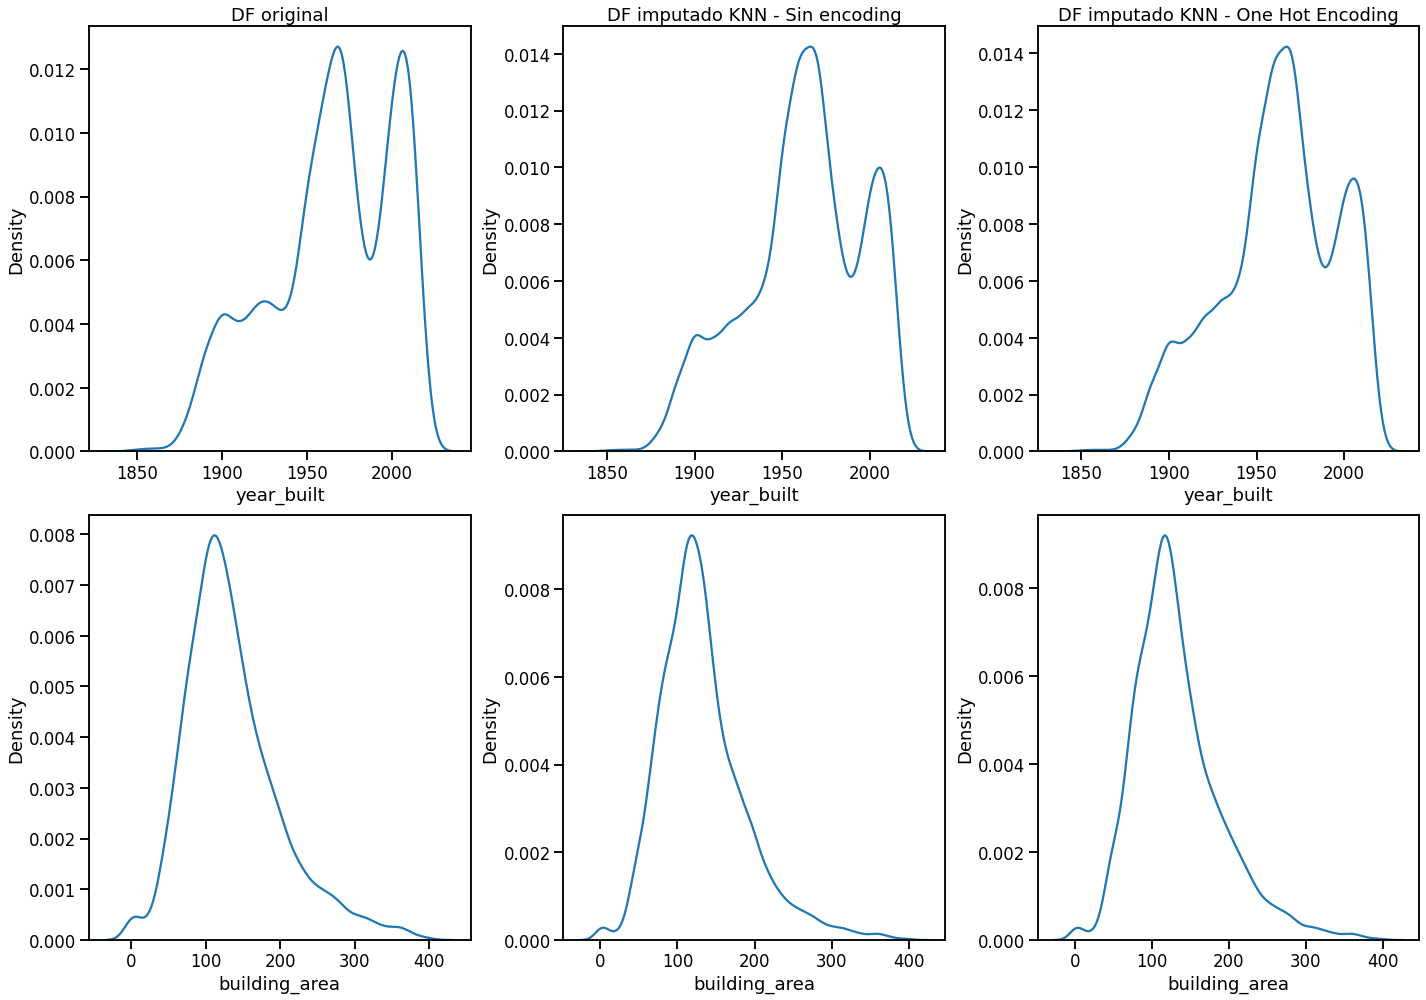

In [ ]:
fig, axes = plt.subplots(2,3,figsize=(20,14))
sns.kdeplot(data = melb_df, x='year_built', ax=axes[0,0])
sns.kdeplot(data = melb_data_knn_num_imputed.rename(columns={17:'year_built'}), x='year_built', ax=axes[0,1])
sns.kdeplot(data = melb_data_array_imputed.rename(columns={92:'year_built'}), x='year_built', ax=axes[0,2])
sns.kdeplot(data = melb_df, x='building_area', ax=axes[1,0])
sns.kdeplot(data = melb_data_knn_num_imputed.rename(columns={18:'building_area'}), x='building_area', ax=axes[1,1])
sns.kdeplot(data = melb_data_array_imputed.rename(columns={93:'building_area'}), x='building_area', ax=axes[1,2])
#building_area
# axes = axes.flatten()
axes[0,0].set_title('DF original')
axes[0,1].set_title('DF imputado KNN - Sin encoding')
axes[0,2].set_title('DF imputado KNN - One Hot Encoding')
fig.tight_layout()



## Ejercicio 3: Reducción de dimensionalidad.

Utilizando la matriz obtenida en el ejercicio anterior:
1. Aplique `PCA` para obtener $n$ componentes principales de la matriz, donde `n = min(20, X.shape[0])`. ¿Es necesario estandarizar o escalar los datos?
2. Grafique la varianza capturada por los primeros $n$ componentes principales, para cada $n$.
3. En base al gráfico, seleccione las primeras $m$ columnas de la matriz transformada para agregar como nuevas características al conjunto de datos.

In [ ]:
encoded

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [ ]:
#PCA depende de la cantidad de varianza, con lo que es necesario estandarizar los datos para no seleccionar 
#como dato de mayor varianza, a una columna que simplemente tiene mayor rango de valores posibles.

#Se recupera entonces la columna suburb_grouped, eliminada del análisis por KNN por temas de memoria, y se utiliza la imputación realizada por KNN:
# categorical_encoder = OneHotEncoder(sparse=False)
# categorical_encoder.fit(melb_df[['suburb_grouped', 'type', 'council_area']])
# encoded_categorical_types = categorical_encoder.transform(melb_df[['suburb_grouped', 'type', 'council_area']])
# melb_df_array = np.hstack((encoded_categorical_types, melb_data_knn_num_imputed))

#Se estandarizan los datos
x = melb_data_array_imputed #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
melb_df_array_scaled = pd.DataFrame(x_scaled)

#Se realiza PCA
from sklearn.decomposition import PCA

n = min(150, x.shape[1])
pca = PCA(n_components=n)
pca.fit(x_scaled)
print("Principal components")
print(pca.components_)
print("Explained variance: ")
print(pca.explained_variance_)
print("Explained variance ratio")
print(pca.explained_variance_ratio_)



Principal components
[[-3.93420240e-03 -4.50664855e-03 -1.04149067e-02 ...  1.90889688e-02
  -5.40968258e-03 -1.12927199e-01]
 [ 6.55463991e-03 -4.44574141e-03  2.70030835e-02 ...  2.52677927e-02
   1.10193163e-01  3.83880035e-02]
 [-2.64791446e-03 -8.90948614e-03 -3.81174968e-03 ...  1.57390985e-03
   7.31709892e-02 -3.67135396e-02]
 ...
 [ 0.00000000e+00  3.74700271e-16  5.77452006e-16 ...  1.56125113e-16
   2.08166817e-16 -3.98986399e-17]
 [-0.00000000e+00 -1.24900090e-16  1.16351271e-17 ...  4.85722573e-17
  -5.55111512e-17  4.73958980e-16]
 [ 0.00000000e+00  5.41233725e-16 -1.91509727e-16 ... -4.85722573e-17
  -5.55111512e-17 -1.37639466e-16]]
Explained variance: 
[7.83185084e-01 4.00084870e-01 3.07064735e-01 2.61864614e-01
 2.16895720e-01 1.48032403e-01 1.46964763e-01 1.33061257e-01
 1.23976196e-01 1.15261009e-01 1.13653346e-01 1.12786470e-01
 1.07818710e-01 1.07129673e-01 1.05702210e-01 1.03581144e-01
 1.00955667e-01 9.84920337e-02 9.64936750e-02 9.45169722e-02
 9.32650661e-02 9

Text(0.5, 1.0, 'Explained variance ratio acumulado por componente principal')

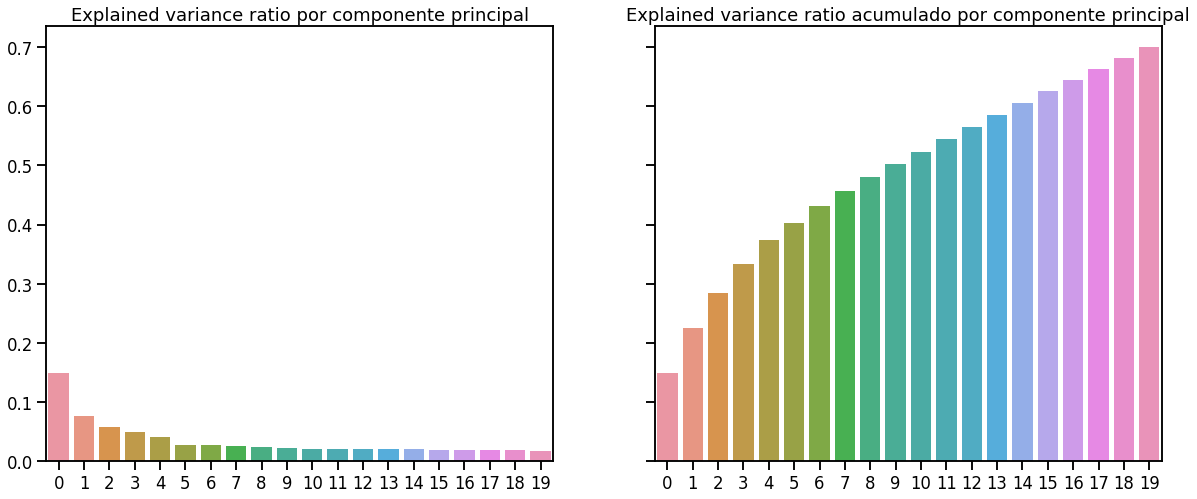

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(20,8), sharey=True)
sns.barplot(x=[i for i in range(20)], y=[pca.explained_variance_ratio_[i] for i in range(20)], ax=axes[0])
sns.barplot(x=[i for i in range(20)], y=[sum([pca.explained_variance_ratio_[i] for i in range(x)]) for x in range(1,21)], ax=axes[1])
axes[0].set_title('Explained variance ratio por componente principal')
axes[1].set_title('Explained variance ratio acumulado por componente principal')


In [ ]:
print('Varianza explicada con tan solo 20 componentes:', sum([pca.explained_variance_ratio_[i] for i in range(20)]))
print('Varianza explicada con 45 componentes:', sum([pca.explained_variance_ratio_[i] for i in range(45)]))
print('Dimensiones dataset original:', x.shape[1])

Varianza explicada con tan solo 20 componentes: 0.6997879734395125
Varianza explicada con 40 componentes: 0.9604987570967491
Dimensiones dataset original: 94


La columna suburb grouped contiene mucha información relevante. La dimensionalidad por ende es muy elevada. Con 20 Principal Components, recién alcanzamos a explicar el 57% de la varianza. Necesitamos 150 para alcanzar valores mayores al 90%.


## Ejercicio 4: Composición del resultado

Transformar nuevamente el conjunto de datos procesado en un `pandas.DataFrame` y guardarlo en un archivo.

Para eso, será necesario recordar el nombre original de cada columna de la matriz, en el orden correcto. Tener en cuenta:
1. El método `OneHotEncoder.get_feature_names` o el atributo `OneHotEncoder.categories_` permiten obtener una lista con los valores de la categoría que le corresponde a cada índice de la matriz.
2. Ninguno de los métodos aplicados intercambia de lugar las columnas o las filas de la matriz.

In [ ]:
prefixes = [col+'=' for col in encoded_columns]
columns = [prefixes[i]+str(item) for i, arr in enumerate(categorical_encoder.categories_) for item in arr] \
            + melb_df.drop(encoded_columns + ['distance','price_mean_1km'], axis=1).columns.tolist()
df = pd.DataFrame(melb_df_array, columns=columns)

df[['PCA_1','PCA_2']] =  pca.transform(x_scaled)[:,:2]
df.head(2)

,council_area=Banyule,council_area=Bayside,council_area=Boroondara,council_area=Brimbank,council_area=Cardinia,council_area=Casey,council_area=Darebin,council_area=Frankston,council_area=Glen Eira,council_area=Greater Dandenong,council_area=Hobsons Bay,council_area=Hume,council_area=Kingston,council_area=Knox,council_area=Macedon Ranges,council_area=Manningham,council_area=Maribyrnong,council_area=Maroondah,council_area=Melbourne,council_area=Melton,council_area=Monash,council_area=Moonee Valley,council_area=Moorabool,council_area=Moreland,council_area=Nillumbik,council_area=Port Phillip,council_area=Stonnington,council_area=Unavailable,council_area=Whitehorse,council_area=Whittlesea,type=h,type=t,type=u,rooms=1,rooms=2,rooms=3,rooms=4,rooms=5,rooms=6,rooms=7,...,car=7.0,car=8.0,car=9.0,car=10.0,"distance_cat=(-0.001, 3.6]","distance_cat=(3.6, 5.5]","distance_cat=(5.5, 6.9]","distance_cat=(6.9, 8.0]","distance_cat=(8.0, 9.3]","distance_cat=(9.3, 11.2]","distance_cat=(11.2, 12.1]","distance_cat=(12.1, 13.8]","distance_cat=(13.8, 16.1]","distance_cat=(16.1, 47.3]","price_mean_1km_cat=(11.999, 64.379]","price_mean_1km_cat=(64.379, 77.308]","price_mean_1km_cat=(77.308, 85.0]","price_mean_1km_cat=(85.0, 91.448]","price_mean_1km_cat=(91.448, 97.371]","price_mean_1km_cat=(97.371, 102.838]","price_mean_1km_cat=(102.838, 109.371]","price_mean_1km_cat=(109.371, 117.824]","price_mean_1km_cat=(117.824, 126.959]","price_mean_1km_cat=(126.959, 280.0]",lat,lng,price,land_size,count_1km,review_mean_1km,count_2km,price_mean_2km,review_mean_2km,count_2.5km,price_mean_2.5km,review_mean_2.5km,year_built,building_area,PCA_1,PCA_2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-37.7996,144.9984,1480000.0,202.0,205.0,9.652941,1146.0,120.191972,9.821814,1799.0,119.989994,9.850208,NaN,NaN,1.044747,-0.062014
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-37.8079,144.9934,1035000.0,156.0,424.0,9.785311,1449.0,122.149068,9.852740,2002.0,122.017483,9.854309,1900.0,79.0,0.750655,-0.192415


## Ejercicio 5: Documentación

En un documento `.pdf` o `.md` realizar un reporte de las operaciones que realizaron para obtener el conjunto de datos final. Se debe incluir:
  1. Criterios de exclusión (o inclusión) de filas
  2. Interpretación de las columnas presentes
  2. Todas las transofrmaciones realizadas

Este documento es de uso técnico exclusivamente, y su objetivo es permitir que otres desarrolladores puedan reproducir los mismos pasos y obtener el mismo resultado. Debe ser detallado pero consiso. Por ejemplo:

```
  ## Criterios de exclusión de ejemplos
  1. Se eliminan ejemplos donde el año de construcción es previo a 1900

  ## Características seleccionadas
  ### Características categóricas
  1. Type: tipo de propiedad. 3 valores posibles
  2. ...
  Todas las características categóricas fueron codificadas con un
  método OneHotEncoding utilizando como máximo sus 30 valores más 
  frecuentes.
  
  ### Características numéricas
  1. Rooms: Cantidad de habitaciones
  2. Distance: Distancia al centro de la ciudad.
  3. airbnb_mean_price: Se agrega el precio promedio diario de 
     publicaciones de la plataforma AirBnB en el mismo código 
     postal. [Link al repositorio con datos externos].

  ### Transformaciones:
  1. Todas las características numéricas fueron estandarizadas.
  2. La columna `Suburb` fue imputada utilizando el método ...
  3. Las columnas `YearBuilt` y ... fueron imputadas utilizando el 
     algoritmo ...
  4. ...

  ### Datos aumentados
  1. Se agregan las 5 primeras columnas obtenidas a través del
     método de PCA, aplicado sobre el conjunto de datos
     totalmente procesado.
```
